# Topic Modeling with BERTopic

BERTopic est une méthode proposée par Maarten Grootendorst pour détecter les "topics", c'est-à-dire les thèmes d'un corpus de texte en s'appuyant sur des modèles de langue SBERT. Après avoir "embeddé" le corpus à l'aide d'un modèle SBERT, BERTopic utilise UMAP pour réduire les dimensions puis HDBSCAN pour identifier les clusters. Enfin, il labellise les clusters à l'aide des 5, 10, 15 chaînes de caractères (le nombre est laissé au choix de l'utilisateur.trice) les plus spécifiques de chaque cluster. Pour cela, il utilise le "c-TF-IDF" (class-based TF-IDF).

Néanmoins, une des spécificités de BERTopic est d'être modulable. Il est ainsi possible d'utiliser d'autres modèles d'embedding, de réduire les dimensions à l'aide d'une analyse en composante principale (ACP ou PCA en anglais) et d'utiliser la méthode des k-means pour la clusterisation.

Dans la suite du notebook, nous allons revenir sur chacune des étapes dans le but d'identifier les "topics" caractérisant un corpus de tweets en français publiés au cours des dix dernières et portant sur les pesticides.

## Importation des données depuis github

In [3]:
import pandas as pd 

In [4]:
url = 'https://raw.githubusercontent.com/luneauaymeric/pesticides_bertopic/refs/heads/main/datas/pesticides_on_twitter2.csv' # liens vers le dépôt github 
path = "datas/pesticides_on_twitter.csv"
df = pd.read_csv(path, dtype= {"id": str, "user_id": str}) #On utilise pandas pour lire le csv


In [5]:
df["text_id"] = "id_" + df.index.astype(str)

## Pre-process Text

Avant de donner notre corpus à Bertopic, il est utile de nettoyer les textes pour enlever les urls, les emojis et les majuscules. On ne garde ensuite que les tweets ayant plus de deux chaines de caractères.



In [6]:
import re #librairie pour les regex
import nltk


In [7]:
df["clean_text"] = df.apply(lambda row: re.sub(r"http\S+", "", str(row.text)).lower(), 1) # remove urls
df["clean_text"] = df.apply(lambda row: re.sub(r"_p_", "", str(row.clean_text)).lower(), 1)
df["clean_text"] = df.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.clean_text.split())), 1) #remove mentioned names
df["clean_text"] = df.apply(lambda row: " ".join(re.sub("[^a-zA-Zàâäéèêëïîôöùûüÿçß]+", " ", row.clean_text).split()), 1) #remove hashtag, arobase, HTML character
df["tokens"] = df.apply(lambda row: nltk.tokenize.wordpunct_tokenize(row.clean_text),1) # 
df[["text", "clean_text"]].head(10)

text  \
0  @JMHauteville Sam 03 Avril 15h Visioconférence...   
1  L'UE décide d'interdire trois pesticides dange...   
2  Concentration élevée de #glyphosate dans les u...   
3  Procès Monsanto : Un jury américain a condamné...   
4  @genefutures @vinel_benoit @petitnavire @Veill...   
5  @Thierry_28000 @fanch_mrl @M_Orphelin @Anses_f...   
6  Au détour d’un scrolling facebook, découverte ...   
7  @libe Une maman se bat pour son fils atteint d...   
8  Plan Ecophyto 2018 : une légère baisse de l'ut...   
9  La #FNSEA des empoisonneurs de la terre l'eau ...   

                                          clean_text  
0  sam avril h visioconférence du sur le chlordéc...  
1  l ue décide d interdire trois pesticides dange...  
2  concentration élevée de glyphosate dans les ur...  
3  procès monsanto un jury américain a condamné v...  
4  sur le sujet des épices et graines contaminées...  
5  depuis quand l ineris est responsable de l hom...  
6  au détour d un scrolling facebook découverte d...  
7  une maman se bat pour son fils atteint d un ca...  
8  plan ecophyto une légère baisse de l utilisati...  
9  la fnsea des empoisonneurs de la terre l eau l...

In [8]:
df["len_txt"] = df.tokens.str.len()
df1 = df.loc[df.len_txt >= 3]#.sample(frac=0.10, replace=True, random_state=42)
print(f"Il y a {len(df1)} tweets. Le plus long fait {max(df1.len_txt)} caractères.")

Il y a 19889 tweets. Le plus long fait 176 caractères.


In [9]:
texts_id = df1.id.to_list()
texts = df1.clean_text.to_list()


## Rapide aperçu de BERTopic

Avant d'aller dans le détail, je vous propose de regarder le type de résultat que retourne BERTopic en utilisant les paramètres par défaut de la fonction éponyme. Nous allons juste changer la langue en choisissant `language="multilingual"` (par défaut, `language="english"`). Ce changement n'est pas totalement anodin, car il conduit "BERTopic" a utilisé un autre modèle d'embedding appelé `paraphrase-multilingual-MiniLM-L12-v2` (https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)



The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"`
and `paraphrase-multilingual-MiniLM-L12-v2` when selecting `language="multilingual"`.

In [10]:
import bertopic

/home/aymeric/anaconda3/envs/audition/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = bertopic.BERTopic(language='multilingual')

topics = model.fit_transform(texts)

In [ ]:
freq = model.get_topic_info()
freq

In [ ]:

freq.Count.iloc[0] / np.sum(freq.Count)

## Décomposition de BERTopic

BERTopic est composé de quatre "étapes" :

1. Le plongement lexical des termes/phrases du corpus à l'aide d'un modèle de langue (BERTopic a été initialement conçu pour fonctioner avec des modèles SBERT)
2. La réduction de la dimensionalité de l'espace vectoriel obtenu à la fin de la première étape
3. L'extraction de clusters
4. La labellisation des clusters en utilisant c-TF-IDF

Le point essentiel à retenir est que chacune des fonctions utilisées pour réaliser ces 4 étapes possèdent des paramètres dont la définition joue ensuite sur le résultat final.

### Embeddings


In [11]:
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import pickle

In [60]:


model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print(model)
print("Les dimensions du modèle :", model.get_sentence_embedding_dimension())



SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
Les dimensions du modèle : 384


In [14]:
saved_embedding = True
if saved_embedding == True:
    with open('tw_embedding_paraphrase-multilingual-MiniLM-L12-v2.pickle', 'rb') as pkl:
        embeddings = pickle.load(pkl)
else:
    embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)
    

### Réduction des dimensions avec UMAP




In [15]:
import numpy as np
import umap

#librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

100%|█████████████████████████████████████████████| 9/9 [01:26<00:00,  9.60s/it]


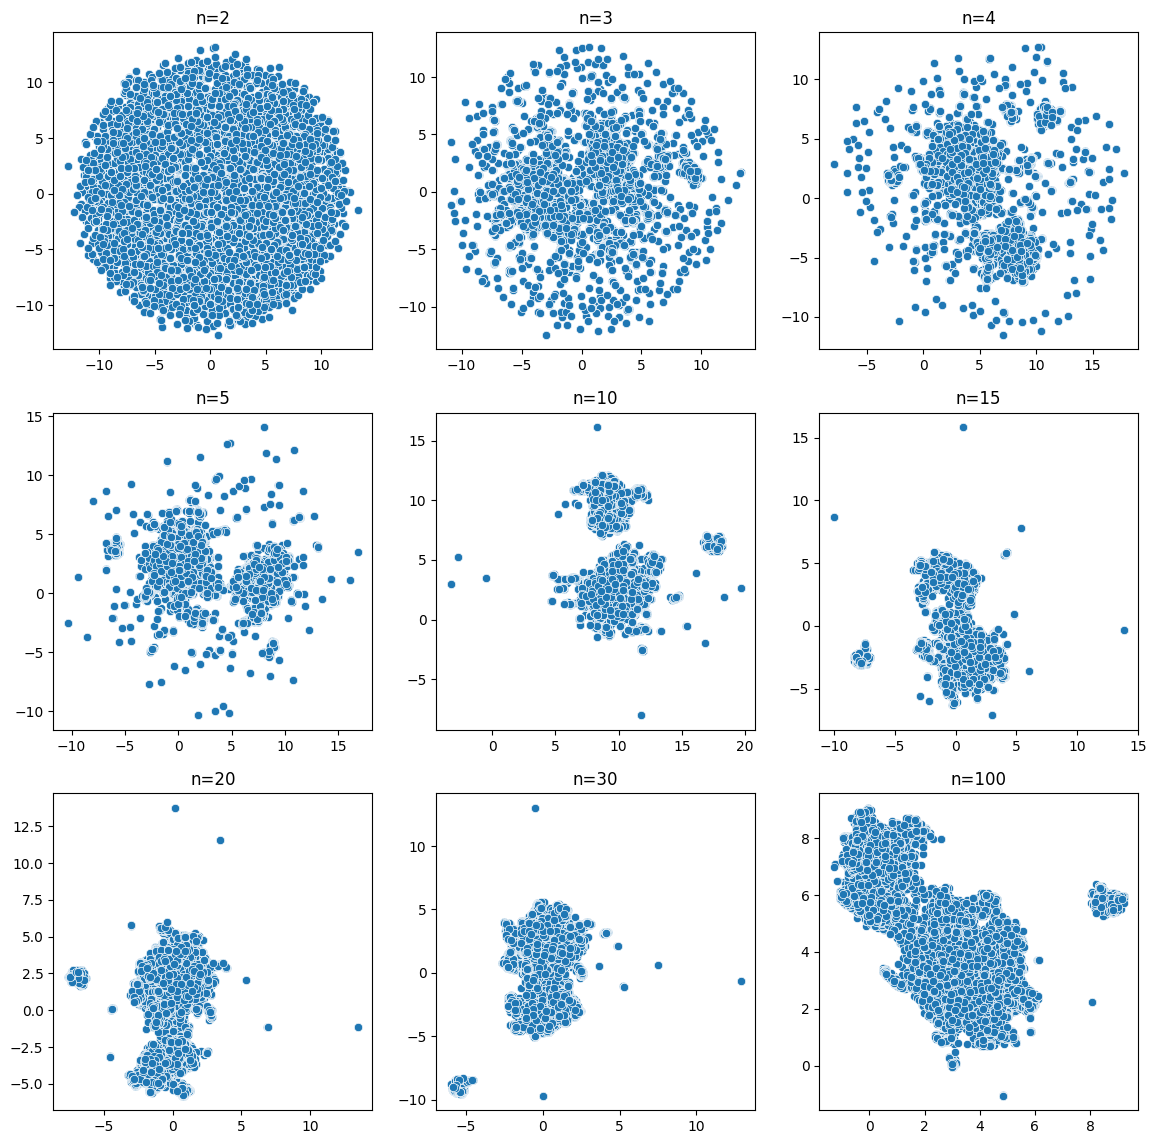

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nns = [2, 3, 4, 5, 10, 15, 20, 30, 100]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors, random_state=42, n_components=2, min_dist=0.01)
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1],  ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

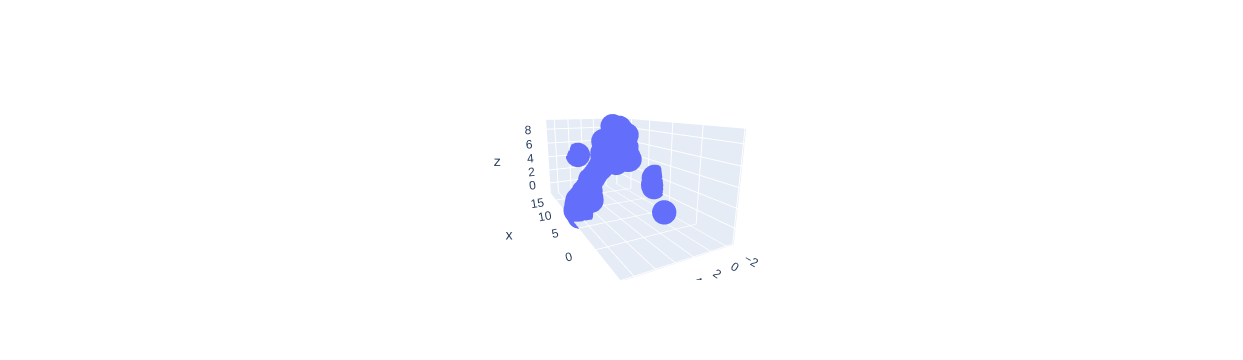

In [17]:
fit = umap.UMAP(n_neighbors=15, 
                       n_components=10, 
                       min_dist=0.00,
                       metric='cosine',
                       random_state=42)
u = fit.fit_transform(embeddings)

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    #color=data['sub'][:n],
    #custom_data=[data['sub'][:n], data['title'][:n]],
    #color_discrete_sequence=palette
)
fig.update_traces(
    
)


In [18]:
umap_model = umap.UMAP(n_neighbors=15, 
                       n_components=10, 
                       min_dist=0.00,
                       metric='cosine',
                       random_state=42)

### Clustering avec HDBSCAN

In [19]:
import hdbscan


18


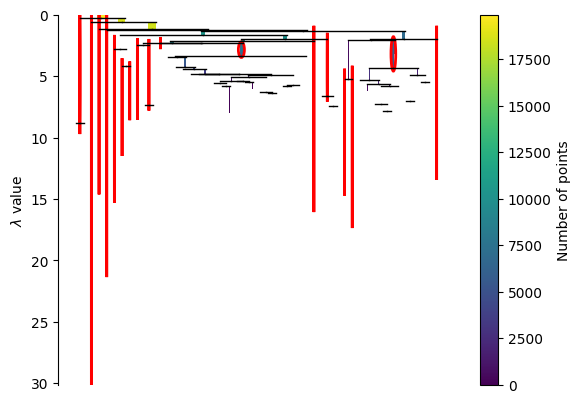

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80, 
                        metric='euclidean', 
                        min_samples= 10,
                        cluster_selection_method='eom', 
                        prediction_data=True)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)
print(len([x for x in set(clusterer.labels_)]))

In [25]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=80, 
                        metric='euclidean', 
                        min_samples= 10,
                        cluster_selection_method='eom', 
                        prediction_data=True)

### c-TF-IDF

In [26]:
from bertopic.vectorizers import ClassTfidfTransformer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
final_stopwords_list = stopwords.words('french')

In [28]:
vectorizer_model = CountVectorizer(ngram_range=(1, 1),
                                   strip_accents='unicode',
                                   #tokenizer=tok, 
                                    stop_words= final_stopwords_list)


In [29]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [30]:
topic_model = bertopic.BERTopic(
    language="multilingual",
    #embedding_model= model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    calculate_probabilities=True,        
    verbose=True
)

In [31]:
topics, probs = topic_model.fit_transform(texts, embeddings)

2024-09-26 16:12:56,308 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-26 16:13:06,450 - BERTopic - Dimensionality - Completed ✓
2024-09-26 16:13:06,451 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-26 16:13:07,807 - BERTopic - Cluster - Completed ✓
2024-09-26 16:13:07,810 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-26 16:13:08,035 - BERTopic - Representation - Completed ✓


In [32]:
print("Nombre de topics (moins les outliers) : ", len(set(topics))-1)

Nombre de topics (moins les outliers) :  17


In [61]:
topic_model = bertopic.BERTopic.load("embed_paraphrase-multilingual-mpnet-base-v2_umap_15_10_hdbscan_80_10")
topic_model

# Load from directory
loaded_model = bertopic.BERTopic.load("embed_paraphrase-multilingual-mpnet-base-v2_umap_15_10_hdbscan_80_10_safetensors", embedding_model=model)

In [64]:
print(loaded_model.embedding_model)

### Visualiser les topics

In [38]:
#topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=True, word_length=20, separator=", ")
#topic_model.set_topic_labels(topic_labels)
top_lab = topic_model.get_topic_info()
top_lab.head(6)

Topic  Count                                           Name  \
0     -1    745   -1_endocriniens_ethylene_perturbateurs_fonds   
1      0   7672         0_bio_pesticides_agriculture_pesticide   
2      1   6160         1_glyphosate_glypho_etudes_cancerigene   
3      2   1095      2_abeilles_tueurs_neonicotinoides_abeille   
4      3    844            3_france_europe_europeenne_francais   
5      4    726  4_neonicotinoides_interdiction_betteraves_loi   

                                          CustomName  \
0  -1, endocriniens, ethylene, perturbateurs, fon...   
1  0, bio, pesticides, agriculture, pesticide, sa...   
2  1, glyphosate, glypho, etudes, cancerigene, sc...   
3  2, abeilles, tueurs, neonicotinoides, abeille,...   
4  3, france, europe, europeenne, francais, franc...   
5  4, neonicotinoides, interdiction, betteraves, ...   

                                      Representation  \
0  [endocriniens, ethylene, perturbateurs, fonds,...   
1  [bio, pesticides, agriculture, pesticide, sans...   
2  [glyphosate, glypho, etudes, cancerigene, scie...   
3  [abeilles, tueurs, neonicotinoides, abeille, m...   
4  [france, europe, europeenne, francais, francai...   
5  [neonicotinoides, interdiction, betteraves, lo...   

                                 Representative_Docs  
0  [rappelproduit grand bio valpibio risques prod...  
1  [oui vous avez raison mais vu les contraites q...  
2  [même demande à et servicepublic les contrôles...  
3  [le compte twitter de b pompili aurait il été ...  
4  [il est était là le vrai danger pesticide subs...  
5  [pour compléter et contextualiser l article du...

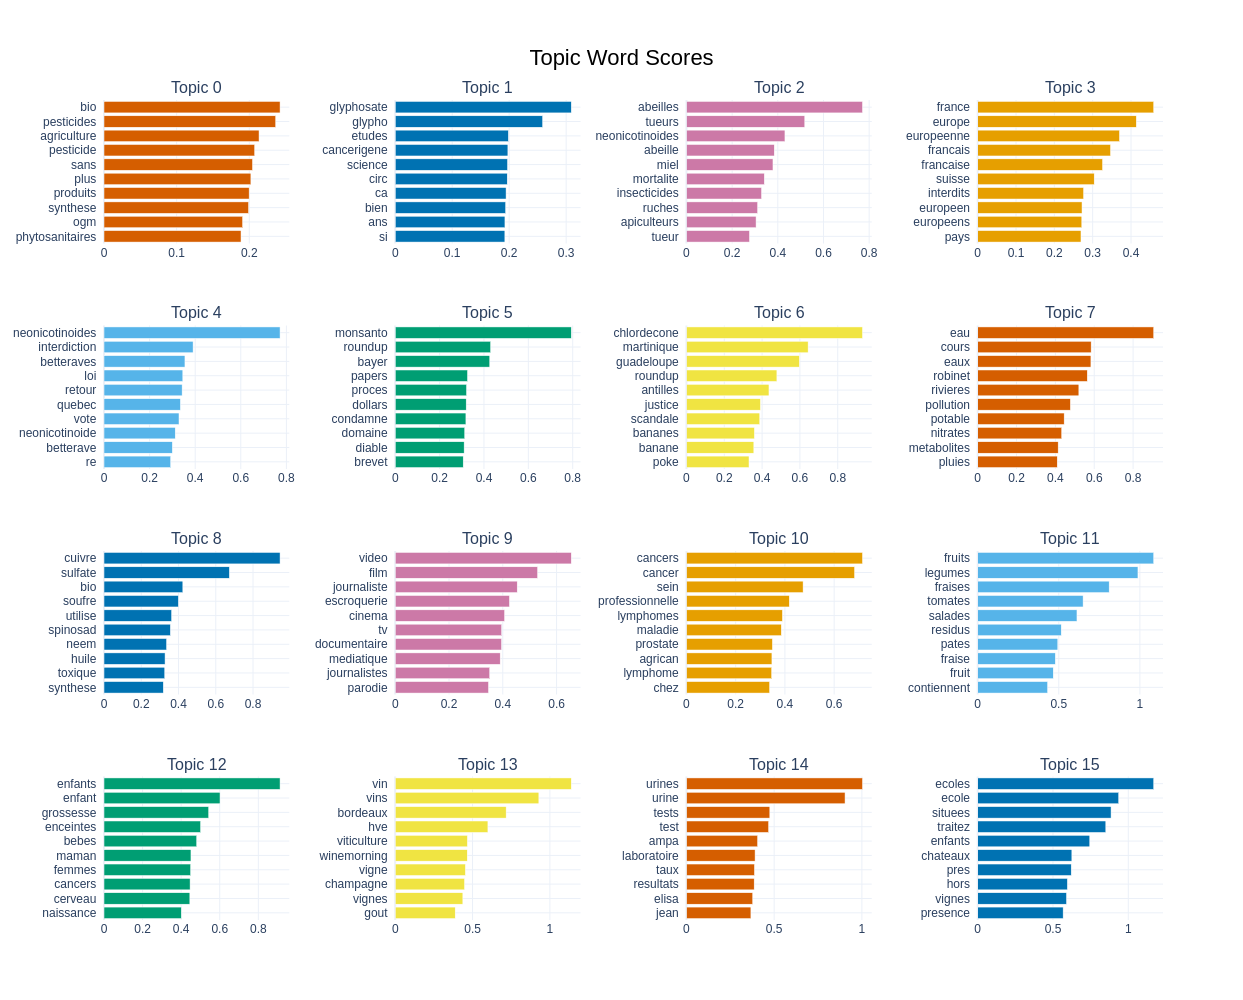

In [47]:
fig = topic_model.visualize_barchart(top_n_topics=20, n_words = 10)
fig
# Décommenter la ligne ci-dessous pour sauvegarder les diagramme
#fig.write_html(f'topic_word_scores_{len(topic_model.get_topic_info())}.html')

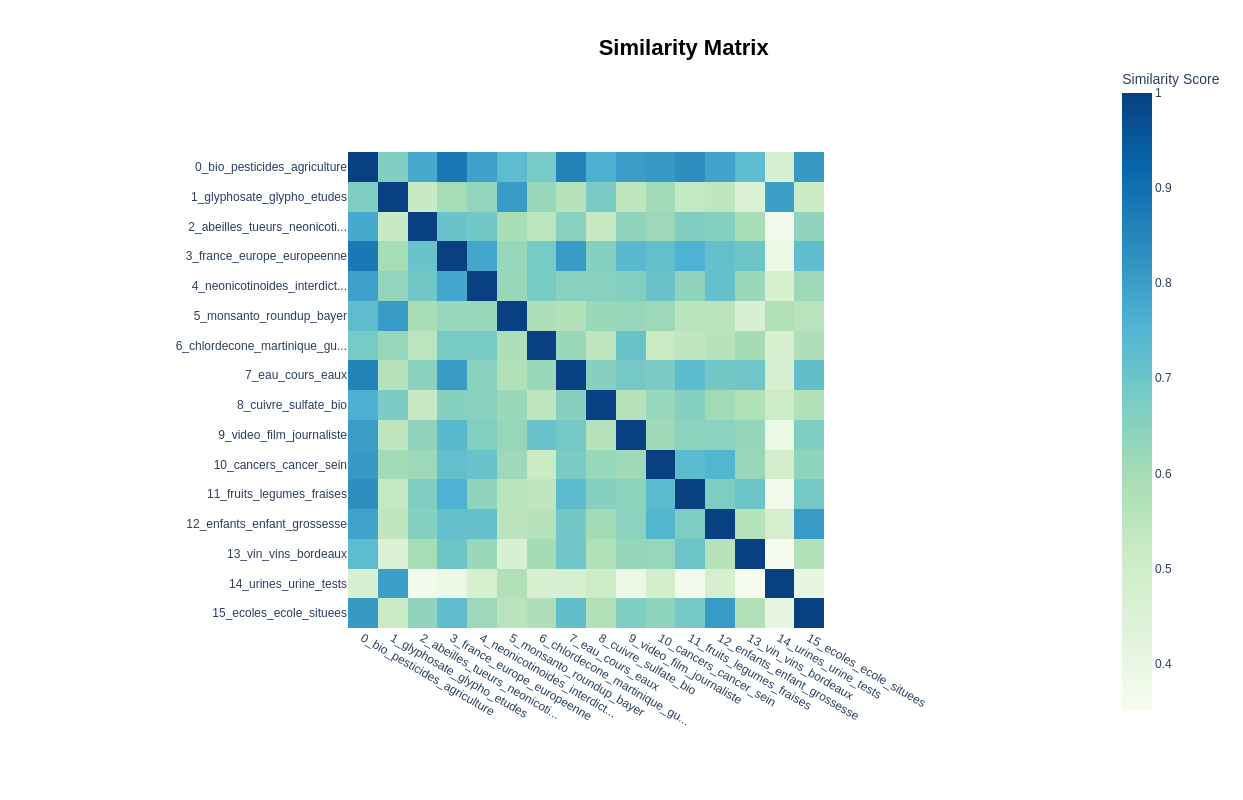

In [67]:
topic_model.visualize_heatmap()

Au risque d'anticiper sur la section suivante, il est possible de "customiser" les labels de différentes façons.

1. Méthode 1 : on demande à bertopic de générer des topics en concaténant les n premiers termes 

In [41]:
topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=True, word_length=20, separator="_")
topic_model.set_topic_labels(topic_labels)

['-1_endocriniens_ethylene_perturbateurs_fonds_oxyde_jobs_indemnisation_pommes_motif_rappelproduit',
 '0_bio_pesticides_agriculture_pesticide_sans_plus_produits_synthese_ogm_phytosanitaires',
 '1_glyphosate_glypho_etudes_cancerigene_science_circ_ca_bien_ans_si',
 '2_abeilles_tueurs_neonicotinoides_abeille_miel_mortalite_insecticides_ruches_apiculteurs_tueur',
 '3_france_europe_europeenne_francais_francaise_suisse_interdits_europeen_europeens_pays',
 '4_neonicotinoides_interdiction_betteraves_loi_retour_quebec_vote_neonicotinoide_betterave_re',
 '5_monsanto_roundup_bayer_papers_proces_dollars_condamne_domaine_diable_brevet',
 '6_chlordecone_martinique_guadeloupe_roundup_antilles_justice_scandale_bananes_banane_poke',
 '7_eau_cours_eaux_robinet_rivieres_pollution_potable_nitrates_metabolites_pluies',
 '8_cuivre_sulfate_bio_soufre_utilise_spinosad_neem_huile_toxique_synthese',
 '9_video_film_journaliste_escroquerie_cinema_tv_documentaire_mediatique_journalistes_parodie',
 '10_cancers_canc

2. On renomme soit-même les topics

In [48]:
topic_model.set_topic_labels({0:"Agriculture et pesticides", 2:"Néonics et abeilles"})
topic_model.get_topic_info()

Topic  Count                                           Name  \
0      -1    745   -1_endocriniens_ethylene_perturbateurs_fonds   
1       0   7672         0_bio_pesticides_agriculture_pesticide   
2       1   6160         1_glyphosate_glypho_etudes_cancerigene   
3       2   1095      2_abeilles_tueurs_neonicotinoides_abeille   
4       3    844            3_france_europe_europeenne_francais   
5       4    726  4_neonicotinoides_interdiction_betteraves_loi   
6       5    636                5_monsanto_roundup_bayer_papers   
7       6    517    6_chlordecone_martinique_guadeloupe_roundup   
8       7    316                       7_eau_cours_eaux_robinet   
9       8    212                    8_cuivre_sulfate_bio_soufre   
10      9    195           9_video_film_journaliste_escroquerie   
11     10    172         10_cancers_cancer_sein_professionnelle   
12     11    149              11_fruits_legumes_fraises_tomates   
13     12    132          12_enfants_enfant_grossesse_enceintes   
14     13    132                       13_vin_vins_bordeaux_hve   
15     14     96                     14_urines_urine_tests_test   
16     15     90                15_ecoles_ecole_situees_traitez   

                                           CustomName  \
0   -1, endocriniens, ethylene, perturbateurs, fon...   
1                           Agriculture et pesticides   
2   1, glyphosate, glypho, etudes, cancerigene, sc...   
3                                 Néonics et abeilles   
4   3, france, europe, europeenne, francais, franc...   
5   4, neonicotinoides, interdiction, betteraves, ...   
6   5, monsanto, roundup, bayer, papers, proces, d...   
7   6, chlordecone, martinique, guadeloupe, roundu...   
8   7, eau, cours, eaux, robinet, rivieres, pollut...   
9   8, cuivre, sulfate, bio, soufre, utilise, spin...   
10  9, video, film, journaliste, escroquerie, cine...   
11  10, cancers, cancer, sein, professionnelle, ly...   
12  11, fruits, legumes, fraises, tomates, salades...   
13  12, enfants, enfant, grossesse, enceintes, beb...   
14  13, vin, vins, bordeaux, hve, viticulture, win...   
15  14, urines, urine, tests, test, ampa, laborato...   
16  15, ecoles, ecole, situees, traitez, enfants, ...   

                                       Representation  \
0   [endocriniens, ethylene, perturbateurs, fonds,...   
1   [bio, pesticides, agriculture, pesticide, sans...   
2   [glyphosate, glypho, etudes, cancerigene, scie...   
3   [abeilles, tueurs, neonicotinoides, abeille, m...   
4   [france, europe, europeenne, francais, francai...   
5   [neonicotinoides, interdiction, betteraves, lo...   
6   [monsanto, roundup, bayer, papers, proces, dol...   
7   [chlordecone, martinique, guadeloupe, roundup,...   
8   [eau, cours, eaux, robinet, rivieres, pollutio...   
9   [cuivre, sulfate, bio, soufre, utilise, spinos...   
10  [video, film, journaliste, escroquerie, cinema...   
11  [cancers, cancer, sein, professionnelle, lymph...   
12  [fruits, legumes, fraises, tomates, salades, r...   
13  [enfants, enfant, grossesse, enceintes, bebes,...   
14  [vin, vins, bordeaux, hve, viticulture, winemo...   
15  [urines, urine, tests, test, ampa, laboratoire...   
16  [ecoles, ecole, situees, traitez, enfants, cha...   

                                  Representative_Docs  
0   [rappelproduit grand bio valpibio risques prod...  
1   [oui vous avez raison mais vu les contraites q...  
2   [même demande à et servicepublic les contrôles...  
3   [le compte twitter de b pompili aurait il été ...  
4   [il est était là le vrai danger pesticide subs...  
5   [pour compléter et contextualiser l article du...  
6   [procès roundup monsanto condamné à payer mill...  
7   [justice chlordécone martinique guadeloupe fra...  
8   [découvrez les cartes de france des eaux de su...  
9   [pourquoi les pesticides de synthèse seraient ...  
10  [comment l industrie des pesticides tente de m...  
11  [si on cherche les inconvénients du principe d...  
12  [on reparle

In [66]:
# Save bertopic model
#topic_model.save("embed_paraphrase-multilingual-mpnet-base-v2_umap_15_10_hdbscan_80_10", save_embedding_model=True)

topic_model.save("embed_paraphrase-multilingual-mpnet-base-v2_umap_15_10_hdbscan_80_10_safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model=model)


### Labelliser les topics

La labellisation des topics suppose un travail d'interprétation. Si dans certains cas, les labels générés par bertopic (ci-après label bertopic) à travers la concaténation des n premiers termes peuvent suffir pour donner du sens aux topics, il s'avère souvent nécessaire de revenir aux textes initiaux pour s'assurer de la pertinence des topics d'une part et proposer une interprétation de ce qui unit les textes regroupés sous un même topic.

1. La première étape consiste à attribuer à chaque texte le numéro et le label bertopic du topic dont il fait partie.

In [50]:
# On ajoute a df1 une colonne "Topic_id"
df1["Topic_id"] = topics # topics est un array à 1 dimension. Il résulte de la commande topics, probs = topic_model.fit_transform(texts, embeddings)


In [52]:
# On ajoute également à df1 une colonne avec les labels bertopic
## On crée un dictionnaire à partir du dataframe "top_lab" où Topic représente le numéro du Topic et Name le label
dict_lab = dict(zip(top_lab.Topic, top_lab.Name))

## On "map" ensuite le dictionnaire pour ajouter les labels à "df1"
df1["Topic_lab"] = df1.Topic_id.map(dict_lab.get)
df1.head(5)

id                                               text  \
0  1378083554404487171  @JMHauteville Sam 03 Avril 15h Visioconférence...   
1   989853171982979077  L'UE décide d'interdire trois pesticides dange...   
2   731136563917230080  Concentration élevée de #glyphosate dans les u...   
3  1028149621623873537  Procès Monsanto : Un jury américain a condamné...   
4  1394648834438057984  @genefutures @vinel_benoit @petitnavire @Veill...   

         date     user_id user_screen_name text_id  \
0  2021-04-02   707547343   ComiteMarche98    id_0   
1  2018-04-27  1055188718        RDurables    id_1   
2  2016-05-13   394088380          BSolist    id_2   
3  2018-08-11    32386128         CDURABLE    id_3   
4  2021-05-18   398227350        Tardisius    id_4   

                                          clean_text  \
0  sam avril h visioconférence du sur le chlordéc...   
1  l ue décide d interdire trois pesticides dange...   
2  concentration élevée de glyphosate dans les ur...   
3  procès monsanto un jury américain a condamné v...   
4  sur le sujet des épices et graines contaminées...   

                                              tokens  len_txt  Topic_id  \
0  [sam, avril, h, visioconférence, du, sur, le, ...       32        13   
1  [l, ue, décide, d, interdire, trois, pesticide...       12         1   
2  [concentration, élevée, de, glyphosate, dans, ...       12         7   
3  [procès, monsanto, un, jury, américain, a, con...       40         0   
4  [sur, le, sujet, des, épices, et, graines, con...       48         1   

                                Topic_lab  
0                13_vin_vins_bordeaux_hve  
1  1_glyphosate_glypho_etudes_cancerigene  
2                7_eau_cours_eaux_robinet  
3  0_bio_pesticides_agriculture_pesticide  
4  1_glyphosate_glypho_etudes_cancerigene

2. On crée un dictionnaire contenant les numéro des topics et les noms que nous allons leurs donner (au départ ce dictionnaire est vide)

In [39]:
topic_name = {
    -1 : "Outliers",
    0 : "Agricultures intensives et pesticides",
    1 : "Glyphosate en débats",
    2 : "Abeilles et néonics",
    3 : "Les pesticides en Frande, en Europe et dans le monde",
    4 : "Néonics et betteraves",
    5 : "Les affaires Monsanto",
    6 : "Chlordécone",
    7 : "Pollution des eaux",
    8 : "Les phytos biologiques",
    9 : "Reportages sur les pesticides",
    10 : "Pesticides et cancers - Etude agrican",
    11 : "Aliments et résidus de pesticides",
    12 : "Enfants et perturbateurs endocriniens",
    13 : "Viticulture",
    14 : "Pisseurs volontaire et test Elisa",
    15 : "Epandage et expositions des riverains"
}

3. On va ensuite faire une boucle pour "sortir" tous les textes du topic que l'on veut inspecter. Une fois qu'on a trouver un nom, on reporte ce nom dans le dictionnaire ci-dessus.

In [56]:
topic_no = 16 #numéro du topic à inspecter

# On filtre df1 pour ne garder que les textes appartenant au topic
dft = df1.loc[(df1["Topic_id"] == topic_no)] 
topic_model.visualize_heatmap()
print(dft.Topic_lab.iloc[0]) ## J'imprime le label bertopic

for n, x in enumerate(dft.clean_text): #Et pour chaque text de dft 
    print("###########")
    print(x)

None
###########
il faut peut être arrêter de croire que les agriculteurs sont des abrutis qui utilisent les produits phytosanitaires pour le plaisir tout comme le conducteur de voiture diesel qui ne prend pas sa voiture que pour son plaisir petit rappel le diesel est cancérigène certain
###########
autant éviter de tomber dans l excès inverse l étude montre des effets du glyphosate sur les générations suivantes à un seuil inférieur au seuil sans effet connu pour les rats on peut aussi le reconnaître
###########
sonde dawn procès roundup et paraplégiques l actu des sciences en ultrabrèves
###########
ben voyons aidons c est cons de paysans qui utilisent des pesticides qui ne servent à rien tuent les abeilles et les ruines vous êtes sur quelle planète telephonemaison
###########
mais pas que le fongicide de préférence ou de dose il faut également le sulfate de magnésie sucre ou coca cola aussi primordial que le fongi
###########
bande annonce du film le roundup face à ses juges de m m r

4. On ajoute une colonne dans `df1` contenant les nouveaux noms des topics. On fait la même chose pour `topic_model`)

In [ ]:
topic_model.set_topic_labels(topic_name) # fonction prévue par bertopic
df1["Topic_name"] = df1.Topic_id.map(topic_name.get)

In [ ]:
df1 = df1.rename(columns=topic_name) #on renomme les colonnes correspondant aux probas des topics en utilisant les nouveaux noms

In [ ]:
# Sauvegarde du dataframe dans un csv / décommenter la ligne ci-dessous
#df1.to_csv("pesticides_on_twitter_with_metadata_umap_15_10_hdbscan_80_10.csv", index = False, sep =",")